# Exploration of results from Bayesian modelling

In [1]:
import numpy as np
import pandas as pd
from matplotlib import cm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
import pymc3 as pm
from tqdm import tqdm

Could not import matplotlib.animation 'ascii' codec can't decode byte 0xc2 in position 90: ordinal not in range(128)


In [2]:
INPUT_FILE = 'n209d1000t500.pickle'

In [3]:
res = pd.read_pickle(INPUT_FILE)
bhsm = res['model']
trace = res['trace']

In [4]:
gal_pa_samples = pd.DataFrame(
    trace['phi_gal'].T,
    index=bhsm.galaxies.index
)

In [5]:
pa_expectation = gal_pa_samples.mean(axis=1)
pa_std = gal_pa_samples.std(axis=1)

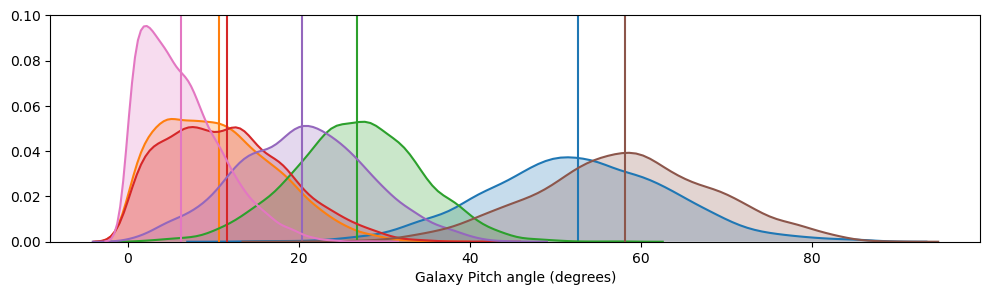

In [6]:
plt.figure(figsize=(12, 3), dpi=100)
sample = pa_expectation.sample(5)
for i, idx in enumerate(sample.index.values.tolist() + [pa_expectation.idxmax(), pa_expectation.idxmin()]):
    sns.kdeplot((gal_pa_samples.loc[idx]), shade=True, color=f'C{i}')
    plt.axvline(gal_pa_samples.loc[idx].mean(), color=f'C{i}')
# i = (gal_pa_samples.idxmax(), gal_pa_samples.idxmin())
plt.xlabel('Galaxy Pitch angle (degrees)')
plt.gca().get_legend().remove()
plt.savefig('plots/gal_pa_kde_sample.png', bbox_inches='tight')

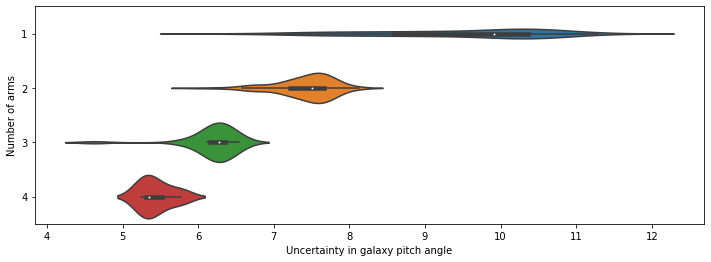

In [7]:
plt.figure(figsize=(12, 4))
sns.violinplot(pa_std, bhsm.galaxies.apply(len), orient='horizontal')
plt.xlabel('Uncertainty in galaxy pitch angle')
plt.ylabel('Number of arms')
plt.savefig('plots/error_vs_n_arms.png', bbox_inches='tight')

## Comparison to length-weighted pitch angles

Let's get some values for the length-weighted pitch angle of our galaxies:

In [8]:
pa_lw_err.loc[bhsm.galaxies[bhsm.galaxies.apply(len) == 1].index]

NameError: name 'pa_lw_err' is not defined

In [9]:
galaxies_df.apply(get_err, axis=1)[bhsm.galaxies[bhsm.galaxies.apply(len) == 1].index].fillna(0)

NameError: name 'galaxies_df' is not defined

In [10]:
# sample extraction
galaxies_df = pd.read_pickle('lib/spiral_arms.pickle')
# keep only galaxies with one arm or more
galaxies_df = galaxies_df[galaxies_df.notna().any(axis=1)]
pa_lw_mean = galaxies_df.apply(
    lambda row: row['pipeline'].get_pitch_angle(row.dropna().values[1:])[0],
    axis=1
).reindex_like(galaxies_df)

def get_err(row):
    return row.dropna()\
      .drop('pipeline')\
      .apply(lambda arm: arm.pa)\
      .std()
pa_lw_err = galaxies_df.apply(get_err, axis=1).reindex_like(galaxies_df).fillna(0)

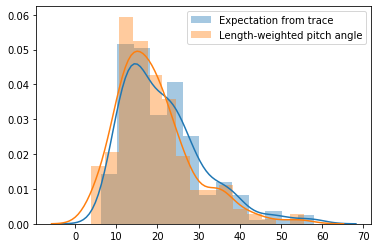

In [11]:
sns.distplot(pa_expectation, label='Expectation from trace')
sns.distplot(pa_lw_mean.dropna(), label='Length-weighted pitch angle')
plt.legend()

In [12]:
lw_df = pd.concat((
    pa_lw_mean.dropna().rename('lw'),
    pa_lw_err.rename('lw_err'),
    pa_expectation.rename('E'),
    pa_std.rename('E_err'),
    bhsm.galaxies.apply(len).rename('n'),
), axis=1).dropna()

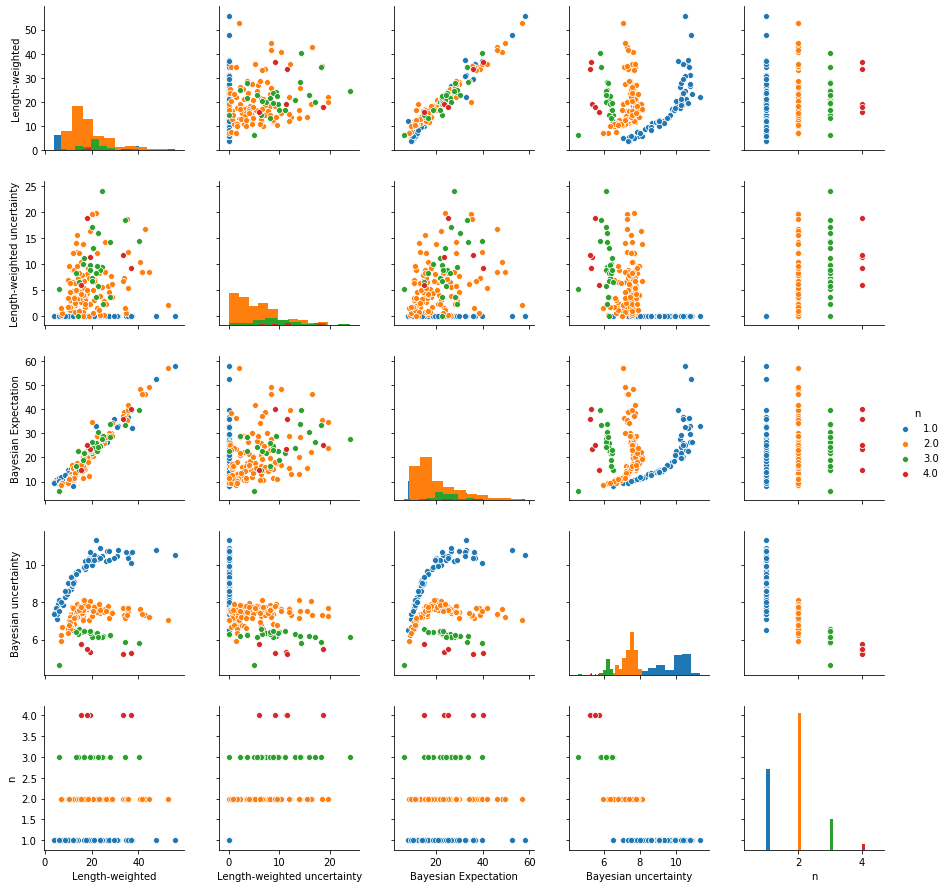

In [13]:
sns.pairplot(
    lw_df.rename(columns=dict(
        lw='Length-weighted',
        lw_err='Length-weighted uncertainty',
        E='Bayesian Expectation',
        E_err='Bayesian uncertainty',
    )),
    hue='n', diag_kind='hist'
)

Text(0, 0.5, 'Expectation from Bayesian modelling')

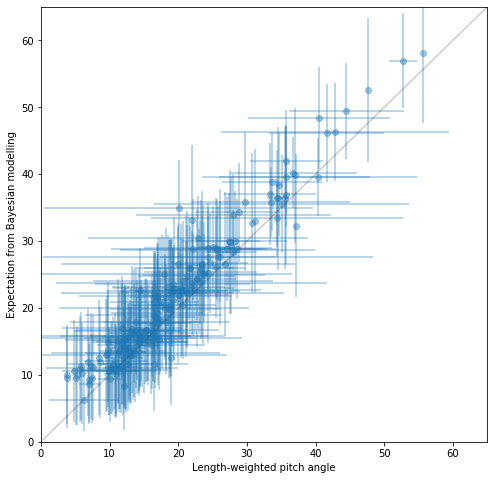

In [14]:
plt.figure(figsize=(8, 8))
plt.errorbar(
    lw_df['lw'], lw_df['E'],
    xerr=lw_df['lw_err'], yerr=lw_df['E_err'],
    fmt='o', alpha=0.4
)
plt.plot((0, 90), (0, 90), c='k', alpha=0.2)
plt.xlim(0, 65)
plt.ylim(0, 65)
plt.xlabel('Length-weighted pitch angle')
plt.ylabel('Expectation from Bayesian modelling')

The values are very consistent, as would be expected. However the measure of error generally used with length-weighted pitch angle measurement (sample error of arm segment pitch angle), does not provide as robust a measurement as the error in the posterior we obtain for $\phi_\mathrm{gal}$.

## Morphology comparison

Does pitch angle vary with bulge or bar strength?

In [15]:
bar_fracs = pd.read_pickle('lib/bar_fractions.pkl')
bulge_fracs = pd.read_pickle('lib/bulge_fractions.pkl')

In [16]:
morphology_comparison = pd.concat((
    bar_fracs.rename(columns={'GZ2 bar fraction': 'bar fraction'}).drop('GZB fraction', axis=1),
    bulge_fracs.rename(columns={'GZ2 no bulge': 'bulge fraction'}).drop('GZB fraction', axis=1),
    pa_expectation.rename('phi'),
    pa_std.rename('sd'),
    bhsm.galaxies.apply(len).rename('n'),
), axis=1).dropna()

In [17]:
n_bulge_dominated = morphology_comparison['GZ2 bulge dominated'].sum()
n_disc_dominated = np.logical_not(morphology_comparison['GZ2 bulge dominated']).sum()
n_bar = morphology_comparison['No bar'].sum()
n_no_bar = np.logical_not(morphology_comparison['No bar']).sum()

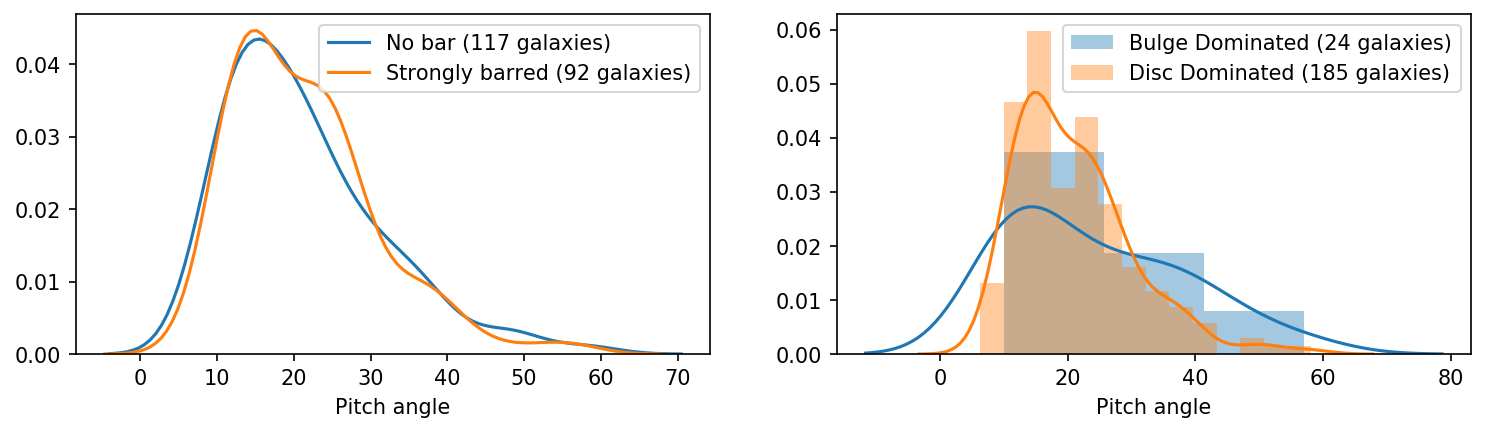

In [18]:
plt.figure(figsize=(12, 3), dpi=150)
plt.subplot(121)
sns.kdeplot(
    morphology_comparison['phi'][morphology_comparison['No bar']].rename('No bar'),
    label=f'No bar ({n_no_bar} galaxies)'
)
sns.kdeplot(
    morphology_comparison['phi'][np.logical_not(morphology_comparison['No bar'])].rename('Bar'),
    label=f'Strongly barred ({n_bar} galaxies)'
)
plt.xlabel('Pitch angle')
plt.subplot(122)
sns.distplot(
    morphology_comparison['phi'][
        morphology_comparison['GZ2 bulge dominated']
    ],
    label=f'Bulge Dominated ({n_bulge_dominated} galaxies)'
)
sns.distplot(
    morphology_comparison['phi'][
        np.logical_not(morphology_comparison['GZ2 bulge dominated'])
    ],
    label=f'Disc Dominated ({n_disc_dominated} galaxies)'
)
plt.xlabel('Pitch angle')
plt.legend()

In [19]:
def set_color_by_correlation(row, cmap=cm.get_cmap('RdYlGn', 12)):
    values = (np.array([cmap((value + 1) / 2) for value in row])  * [256, 256, 256, 1]).astype(int)
    return [f'background-color: rgba{tuple(value.tolist())}' for value in values]

corr_df = morphology_comparison.drop(columns=['No bar', 'Strongly barred', 'GZ2 bulge dominated']).corr(method='kendall')
corr_df.style.apply(set_color_by_correlation)

,bar fraction,bulge fraction,phi,sd,n
bar fraction,1,0.0725646,0.00778965,-0.0931531,0.170404
bulge fraction,0.0725646,1,0.0156806,-0.0155872,0.0366911
phi,0.00778965,0.0156806,1,0.139768,0.125944
sd,-0.0931531,-0.0155872,0.139768,1,-0.705629
n,0.170404,0.0366911,0.125944,-0.705629,1


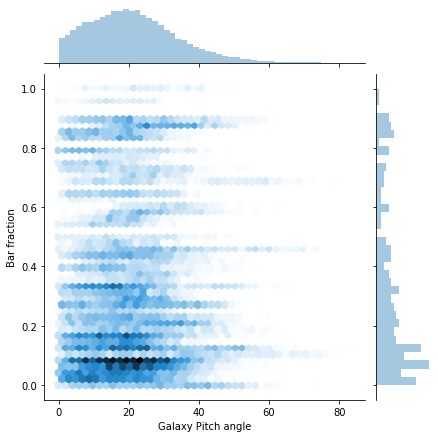

In [20]:
foo = gal_pa_samples.T.sample(100).T
foo = pd.concat((foo, morphology_comparison['bar fraction']), axis=1).values
g = sns.jointplot(foo[:, :-1].ravel(), np.repeat(foo[:, -1], len(foo[0]) - 1), kind='hex')
g.ax_joint.set_xlabel('Galaxy Pitch angle')
g.ax_joint.set_ylabel('Bar fraction')
del foo

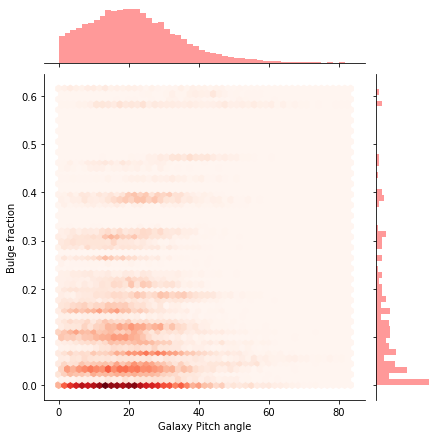

In [21]:
foo = gal_pa_samples.T.sample(100).T
foo = pd.concat((foo, morphology_comparison['bulge fraction']), axis=1).values
g = sns.jointplot(foo[:, :-1].ravel(), np.repeat(foo[:, -1], len(foo[0]) - 1), kind='hex', cmap='Reds', marginal_kws=dict(color='red'))
g.ax_joint.set_xlabel('Galaxy Pitch angle')
g.ax_joint.set_ylabel('Bulge fraction')
del foo

Text(0, 0.5, 'Fraction')

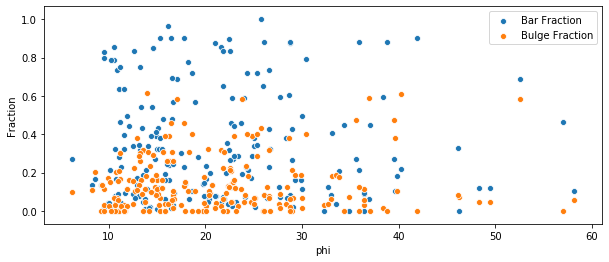

In [22]:
plt.figure(figsize=(10, 4))
sns.scatterplot(x='phi', y='bar fraction', data=morphology_comparison.dropna(), label='Bar Fraction')
sns.scatterplot(x='phi', y='bulge fraction', data=morphology_comparison.dropna(), label='Bulge Fraction')
plt.ylabel('Fraction')

In [23]:
gz2_spiral_data = pd.read_csv('lib/gz2_spiral_data.csv', index_col=0)

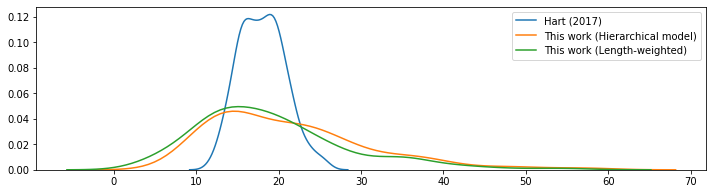

In [24]:
plt.figure(figsize=(12, 3))
sns.kdeplot(gz2_spiral_data['hart_pa'].dropna(), label='Hart (2017)')
sns.kdeplot(pa_expectation, label='This work (Hierarchical model)')
sns.kdeplot(pa_lw_mean.dropna(), label='This work (Length-weighted)')

,GZ2 Winding coefficient,Hart (2017),Expectation,Length-weighted
GZ2 Winding coefficient,1,0.957395,0.437746,0.437633
Hart (2017),0.957395,1,0.376728,0.385381
Expectation,0.437746,0.376728,1,0.968659
Length-weighted,0.437633,0.385381,0.968659,1


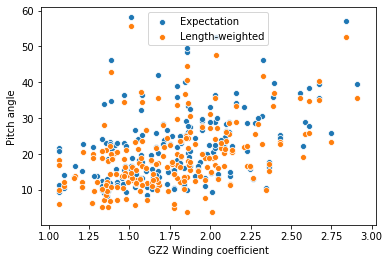

In [25]:
sns.scatterplot(gz2_spiral_data['winding'], pa_expectation, label='Expectation')
sns.scatterplot(gz2_spiral_data['winding'], pa_lw_mean, label='Length-weighted')
plt.xlabel('GZ2 Winding coefficient')
plt.ylabel('Pitch angle')
pd.concat((
    gz2_spiral_data['winding'].rename('GZ2 Winding coefficient'),
    gz2_spiral_data['hart_pa'].rename('Hart (2017)'),
    pa_expectation.rename('Expectation'),
    pa_lw_mean.rename('Length-weighted'),
), axis=1).corr().style.apply(set_color_by_correlation)

Text(0, 0.5, 'This work')

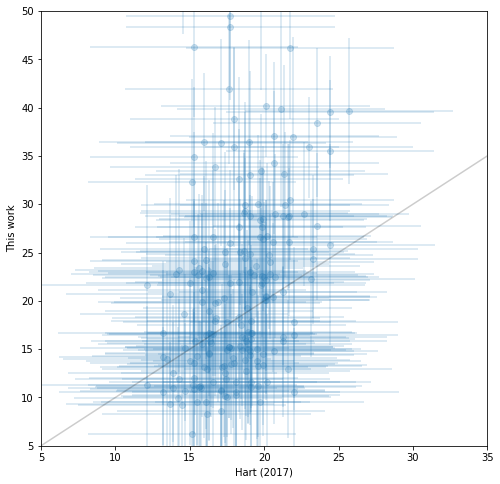

In [26]:
plt.figure(figsize=(8, 8))
df = pd.concat((gz2_spiral_data['hart_pa'], pa_expectation.rename('pa'), pa_std.rename('err')), axis=1).dropna()
plt.errorbar(df['hart_pa'], df['pa'], xerr=7, yerr=df['err'], fmt='o', alpha=0.2)
l = np.stack((plt.ylim(), plt.xlim()))
plt.plot((0, 90), (0, 90), c='k', alpha=0.2)
plt.xlim(5, 35)
plt.ylim(5, 50)
plt.xlabel('Hart (2017)')
plt.ylabel('This work')

## Potential source distributions

[Pringle & Dobbs (2019)](https://arxiv.org/pdf/1909.10291.pdf) propose that for a simple model of spiral awm winding, galaxy pitch angle should be uniform in $\cot\phi$ between some limits. We examine this possibility using repetitions of the Kolmogorov-Smirnov and Anderson-Darling tests for different realizations of the posterior distribution of galaxy pitch angle (which we will refer to as _marginalized tests_). We also invsetigate the Beta distribution and Truncated Normal distribution as possible source distributions.

In [27]:
import scipy.stats as st
import warnings

def cot(phi):
    return 1 / np.tan(np.radians(phi))

def acot(a):
    return np.degrees(np.arctan(1 / a))

warnings.simplefilter('ignore', UserWarning)

In [28]:
LOWER_COT_BOUND = 1.19
UPPER_COT_BOUND = 4.75

lower_phi_bound = acot(UPPER_COT_BOUND)
upper_phi_bound = acot(LOWER_COT_BOUND)

In [29]:
ks = pd.Series([], name='ks_test_result')
anderson = pd.Series([], name='anderson_test_result')
target_dist = st.uniform(LOWER_COT_BOUND, UPPER_COT_BOUND - LOWER_COT_BOUND)
comparison_dataset = target_dist.rvs(10000)
with tqdm(range(trace['phi_gal'].shape[0])) as bar:
    for i in bar:
        phi_gal_est = trace['phi_gal'][i]
        cot_mask = (cot(phi_gal_est) > LOWER_COT_BOUND) & (cot(phi_gal_est) < UPPER_COT_BOUND)
        anderson[i] = st.anderson_ksamp((
            cot(phi_gal_est[cot_mask]),
            comparison_dataset,
        ))
        ks[i] = st.kstest(
            cot(phi_gal_est[cot_mask]),
            target_dist.cdf,
        )
ks = ks.apply(pd.Series).rename(columns={0: 'value', 1: 'p'})
anderson = anderson.apply(pd.Series).rename(columns={0: 'value', 1: 'levels', 2: 'significance'})

100%|██████████| 4000/4000 [00:43<00:00, 91.48it/s] 


Cheeky helper function to do custom logarithmic histogramming:

In [30]:
def do_log_hist(vals):
    counts, bins = np.histogram(np.log10(vals), bins='scott', density=True)
    line = plt.step(10**bins, np.concatenate(([0], counts)), color='C1')[0]
    plt.fill_between(10**np.repeat(bins, 2)[1:-1], np.repeat(counts, 2), color='C1', alpha=0.2)
    plt.xscale('log')

Thresholds:
       25%: 0.33, reject 100% of the time
       10%: 1.23, reject 100% of the time
        5%: 1.96, reject 100% of the time
      2.5%: 2.72, reject 100% of the time
        1%: 3.75, reject 100% of the time


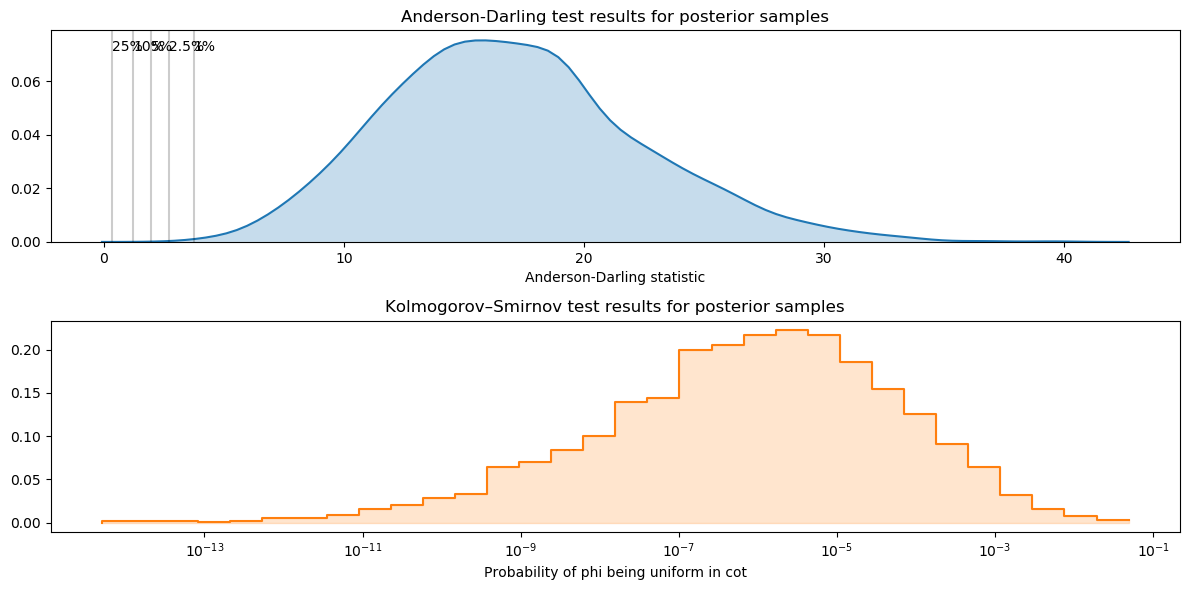

In [31]:
f, ax = plt.subplots(nrows=2, figsize=(12, 6), dpi=100)

plt.sca(ax[0])
plt.title('Anderson-Darling test results for posterior samples')
sns.kdeplot(anderson['value'], label='', shade=True)
print('Thresholds:')
for i, j in zip(
    ('25%', '10%', '5%', '2.5%', '1%'),
    np.stack(anderson['levels'].values).mean(axis=0)
):
    freq = (anderson['value'] >= j).sum() / len(anderson['value'])
    print(f'{i: >10}: {j:.2f}, reject {freq:.0%} of the time')
    plt.axvline(j, color='k', alpha=0.2)
    plt.text(j, plt.ylim()[1]*0.9, i)
plt.xlabel('Anderson-Darling statistic')
plt.sca(ax[1])
plt.title(r'Kolmogorov–Smirnov test results for posterior samples')
do_log_hist(ks['p'])
plt.xlabel(r'Probability of phi being uniform in cot')
plt.tight_layout()
plt.show()

Therefore we can reject the hypothesis that the galaxy pitch angles for our sample are uniformly distributed in $\cot$ between the limits present in [Pringle & Dobbs (2019)](https://arxiv.org/pdf/1909.10291.pdf).

Interestingly, the observed pitch angles **could** be drawn from a Beta distribution:

$$\phi_\mathrm{gal} \sim 90 \times \mathrm{Beta}(a, b)$$

In [32]:
ks_beta = pd.Series([], name='ks_test_result')
anderson_beta = pd.Series([], name='anderson_test_result')
betas = []
with tqdm(range(trace['phi_gal'].shape[0])) as bar:
    for i in bar:
        phi_gal_est = trace['phi_gal'][i]
        beta_fit = st.beta(*st.beta.fit(phi_gal_est, fscale=90, floc=0))
        betas.append(beta_fit)
        anderson_beta[i] = st.anderson_ksamp((
            phi_gal_est,
            beta_fit.rvs(10000),
        ))
        ks_beta[i] = st.kstest(
            phi_gal_est,
            beta_fit.cdf,
        )
ks_beta = ks_beta.apply(pd.Series).rename(columns={0: 'value', 1: 'p'})
anderson_beta = anderson_beta.apply(pd.Series).rename(columns={0: 'value', 1: 'levels', 2: 'significance'})

100%|██████████| 4000/4000 [00:56<00:00, 70.77it/s]


Thresholds:
       25%: 0.33, reject 36% of the time
       10%: 1.23, reject 10% of the time
        5%: 1.96, reject 3% of the time
      2.5%: 2.72, reject 1% of the time
        1%: 3.75, reject 0% of the time


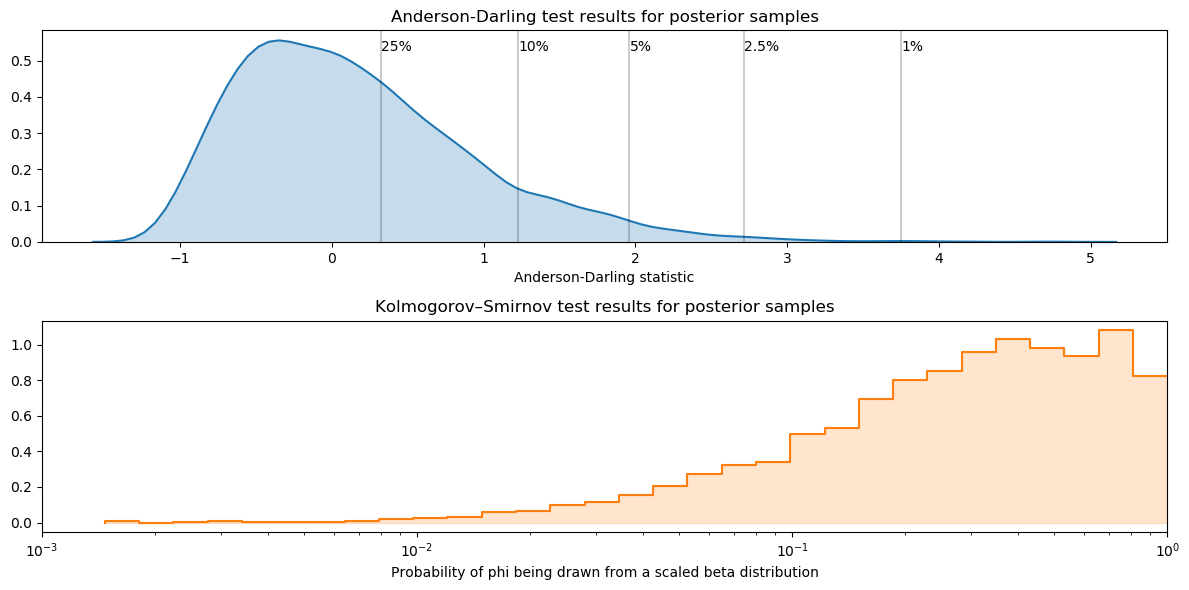

In [33]:
f, ax = plt.subplots(nrows=2, figsize=(12, 6), dpi=100)

plt.sca(ax[0])
plt.title('Anderson-Darling test results for posterior samples')
sns.kdeplot(anderson_beta['value'], label='', shade=True)
print('Thresholds:')
for i, j in zip(
    ('25%', '10%', '5%', '2.5%', '1%'),
    np.stack(anderson_beta['levels'].values).mean(axis=0)
):
    freq = (anderson_beta['value'] >= j).sum() / len(anderson['value'])
    print(f'{i: >10}: {j:.2f}, reject {freq:.0%} of the time')
    plt.axvline(j, color='k', alpha=0.2)
    plt.text(j, plt.ylim()[1]*0.9, i)
plt.xlabel('Anderson-Darling statistic')
plt.sca(ax[1])
plt.title(r'Kolmogorov–Smirnov test results for posterior samples')
# sns.distplot(np.log10(ks_beta['p']), label='', kde=False, norm_hist=True, color='C1')
# plt.xticks(*gen_ticks_labels(-3, 0, 1))
do_log_hist(ks_beta['p'])
plt.xlim(1E-3, 1)
plt.xlabel(r'Probability of phi being drawn from a scaled beta distribution')
plt.tight_layout()
plt.show()

And possibly (and even more likely) a normal distribution truncated between 0 and 90:

In [34]:
def truncnorm(loc, scale, lower=0, upper=90):
    return st.truncnorm(
        (lower - loc) / scale, (upper - loc) / scale,
        loc=loc, scale=scale
    )

def truncnorm_nnlf(loc, scale, data, lower=0, upper=90):
    a, b = (lower - loc) / scale, (upper - loc) / scale
    return st.truncnorm.nnlf((a, b, loc, scale), data)

In [35]:
ks_truncnorm = pd.Series([], name='ks_test_result')
anderson_truncnorm = pd.Series([], name='anderson_test_result')
truncnorms = []
with tqdm(range(trace['phi_gal'].shape[0])) as bar:
    for i in bar:
        phi_gal_est = trace['phi_gal'][i]
        res = minimize(lambda p: truncnorm_nnlf(*p, phi_gal_est), (10, 10))
        truncnorm_fit = truncnorm(*res['x'])
        truncnorms.append(truncnorm_fit)
        anderson_truncnorm[i] = st.anderson_ksamp((
            phi_gal_est,
            truncnorm_fit.rvs(10000),
        ))
        ks_truncnorm[i] = st.kstest(
            phi_gal_est,
            truncnorm_fit.cdf,
        )
ks_truncnorm = ks_truncnorm.apply(pd.Series).rename(columns={0: 'value', 1: 'p'})
anderson_truncnorm = anderson_truncnorm.apply(pd.Series).rename(columns={0: 'value', 1: 'levels', 2: 'significance'})

100%|██████████| 4000/4000 [01:31<00:00, 43.85it/s]


Thresholds:
       25%: 0.33, reject 1% of the time
       10%: 1.23, reject 0% of the time
        5%: 1.96, reject 0% of the time
      2.5%: 2.72, reject 0% of the time
        1%: 3.75, reject 0% of the time


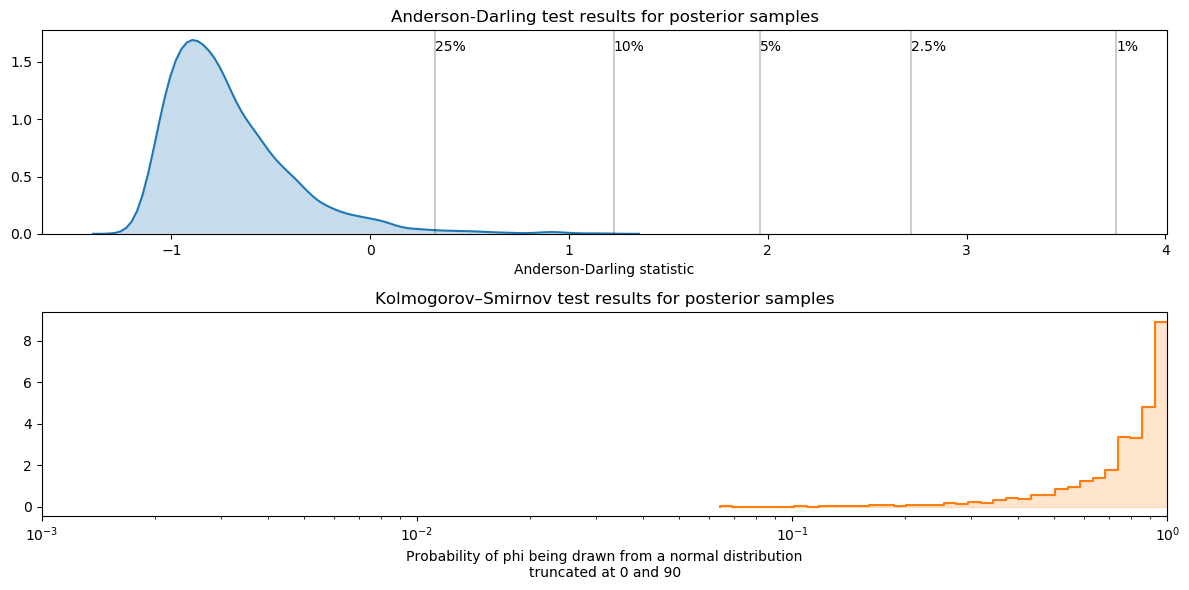

In [36]:
f, ax = plt.subplots(nrows=2, figsize=(12, 6), dpi=100)

plt.sca(ax[0])
plt.title('Anderson-Darling test results for posterior samples')
sns.kdeplot(anderson_truncnorm['value'], label='', shade=True)
print('Thresholds:')
for i, j in zip(
    ('25%', '10%', '5%', '2.5%', '1%'),
    np.stack(anderson_truncnorm['levels'].values).mean(axis=0)
):
    freq = (anderson_truncnorm['value'] >= j).sum() / len(anderson['value'])
    print(f'{i: >10}: {j:.2f}, reject {freq:.0%} of the time')
    plt.axvline(j, color='k', alpha=0.2)
    plt.text(j, plt.ylim()[1]*0.9, i)
plt.xlabel('Anderson-Darling statistic')
plt.sca(ax[1])
plt.title(r'Kolmogorov–Smirnov test results for posterior samples')
do_log_hist(ks_truncnorm['p'])
plt.xlim(1E-3, 1)
plt.xlabel('Probability of phi being drawn from a normal distribution\ntruncated at 0 and 90')
plt.tight_layout()
plt.show()

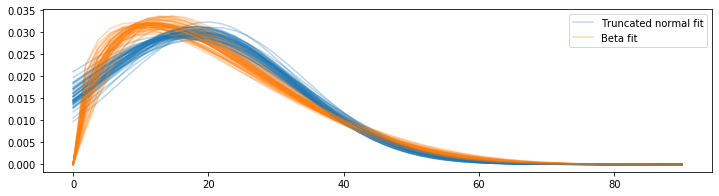

In [54]:
idx = np.random.choice(np.arange(len(truncnorms)), 50)
_x = np.linspace(0, 90)
plt.figure(figsize=(12, 3))
for i in idx:
    tn_l = plt.plot(_x, truncnorms[i].pdf(_x), color='C0', alpha=0.3)
    bt_l = plt.plot(_x, betas[i].pdf(_x), color='C1', alpha=0.3)
    
plt.legend([tn_l[0], bt_l[0]], ['Truncated normal fit', 'Beta fit'])